### Домашнее задание TSML-9 №4

1. Выберите ряд из первого задания.
1. Постройте его модель GARCH.
1. Оформите отчёт в Jupyter-ноутбук.

In [121]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [122]:
import warnings
warnings.filterwarnings('ignore')

In [123]:
def test_stationarity(name,timeseries):
    print(f'Results of Dickey-Fuller Test for {name}:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    return dftest[1]

In [124]:
def tsplot(y, name, lags=None,  figsize=(14, 8), style='bmh'):
    #test_stationarity(y)
    pval=test_stationarity(name,y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(f'{name}')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return pval

In [125]:
#series_femalebirths = pd.read_csv("Series\daily-total-female-births-in-cal.csv")['Count'].dropna()
#series_airline = pd.read_csv("Series\international-airline-passengers.csv")['Count'].dropna()
#series_temperature = pd.read_csv("Series\mean-monthly-air-temperature-deg.csv")['Deg'].dropna().reset_index(drop=True)
#series_robberies = pd.read_csv("Series\monthly-boston-armed-robberies-j.csv")['Count'].dropna()
#series_sales= pd.read_csv("Series\monthly-sales-of-company-x-jan-6.csv")['Count'].dropna()
series_dowjones = pd.read_csv("Series\weekly-closings-of-the-dowjones-.csv")['Close'].dropna().reset_index(drop=True)
series_dowjones.head()

0    890.19
1    901.80
2    888.51
3    887.78
4    858.43
Name: Close, dtype: float64

In [126]:
lst_ser={#'series_femalebirths':series_femalebirths
#,'series_airline':series_airline
#,'series_temperature':series_temperature 
#,'series_robberies':series_robberies,
#'series_sales':series_sales,
'series_dowjones':series_dowjones#,
#'series_femalebirths':series_femalebirths
}

In [127]:
series = lst_ser['series_dowjones']
#lst_ser['series_dowjones'] = boxcox(series, 0)

In [128]:
from arch import arch_model


## GARCH
Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

In [129]:
series = lst_ser['series_dowjones']

Results of Dickey-Fuller Test for series_dowjones:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


Гипотеза H0 о нестационарности series_dowjones принимается, так как (P-value == 6.22E-01) > 5%


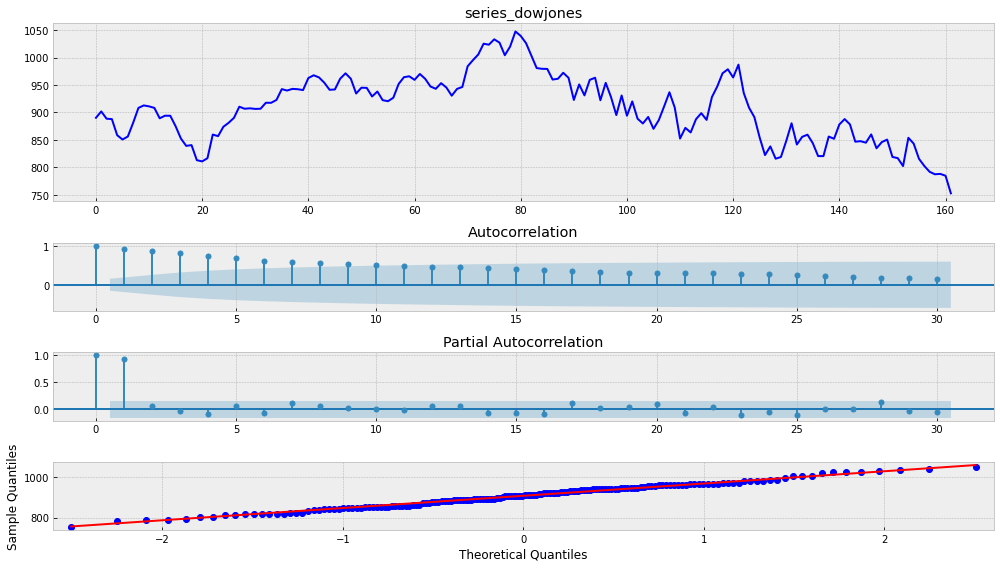

In [130]:
for k,ser in lst_ser.items():
    #ser_ln=np.log(ser)
    loc_p_v=tsplot(ser,k,lags=30)
    if(loc_p_v<0.05):
        dct_ln[k]=ser
        print(f'Гипотеза H0 о нестационарности {k} отвергается, так как (P-value =={loc_p_v : .2E}) < 5%')
    else:
        print(f'Гипотеза H0 о нестационарности {k} принимается, так как (P-value =={loc_p_v : .2E}) > 5%')

In [131]:
am = arch_model(series)
res = am.fit(update_freq=5)
#predict_ts=am.predict(series[-20:])
print(res.summary())

Iteration:      5,   Func. Count:     27,   Neg. LLF: 856.3720128516104
Iteration:     10,   Func. Count:     52,   Neg. LLF: 856.319687981586
Iteration:     15,   Func. Count:     77,   Neg. LLF: 854.7278484727287
Iteration:     20,   Func. Count:    105,   Neg. LLF: 854.1242927398354
Iteration:     25,   Func. Count:    130,   Neg. LLF: 854.123689444717
Optimization terminated successfully    (Exit mode 0)
            Current function value: 854.1236893156082
            Iterations: 26
            Function evaluations: 136
            Gradient evaluations: 26
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -854.124
Distribution:                  Normal   AIC:                           1716.25
Method:            Maximum Likelihood

In [132]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 307.6838
a1 = 0.8321
b1 = 0.1369

n = len(series)
w = np.random.normal(size=n)
eps = lst_ser['series_dowjones']#np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

#tsplot(eps,'series_dowjones', lags=30)

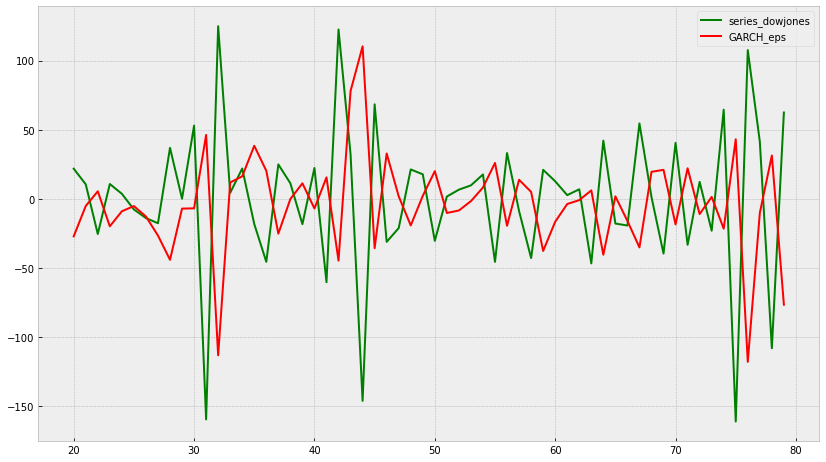

In [133]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    
    plt.plot(pd.Series(np.diff(series_dowjones))[20:80], color='green', label='series_dowjones')
    
    plt.plot(eps[20:80], color='red', label='GARCH_eps')

    plt.legend()
    plt.show()